In [1]:
import tensorflow as tf
import tensorflow_hub as hub

import pandas as pd

from src.data.images import show
from src.utils import get_imgs_paths, get_user_info, get_root_path

from tqdm.notebook import tqdm
%load_ext autoreload
%autoreload 2


# OPTIONAL: Load the "autoreload" extension so that code can change


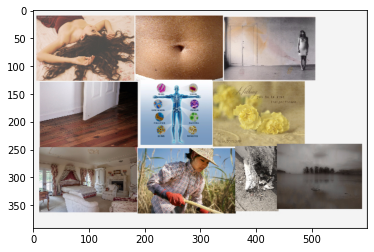

In [63]:
imgs_path = get_imgs_paths()
user_info = get_user_info()

show(imgs_path[2])

Basic simplest approach: embed each collage as standalone image

In [94]:
mobilenet_v2 = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
inception_v3 = "https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4"

IMAGE_SHAPE = (224, 224)


def process_path(file_path: str):
    global IMAGE_SHAPE
    image = tf.io.read_file(file_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (IMAGE_SHAPE))
    image = image / 255.0
    return image, file_path


def extract_embeddings(feature_extractor_model: str, fname: str) -> None:
    batch_size = 32
    feature_extractor_layer = hub.KerasLayer(
        feature_extractor_model,
        input_shape=(224, 224, 3),
        trainable=False)

    ds_train = tf.data.Dataset.list_files([str(i) for i in imgs_path], shuffle=False)
    ds_train = ds_train.map(process_path).batch(batch_size)

    all_tensors = []
    all_paths = []

    for image_batch, image_fpath in tqdm(ds_train):
        result_batch = feature_extractor_layer(image_batch)

        all_tensors.append(result_batch)
        all_paths.append(image_fpath)

    all_tensors = tf.concat(all_tensors, 0)
    all_paths = tf.concat(all_paths, 0)

    destination = get_root_path() / 'data/interim/'
    pd.concat([pd.DataFrame(all_paths.numpy().astype(str), columns=['fileName']),
               pd.DataFrame(all_tensors.numpy())], axis=1).to_csv(destination / fname)


extract_embeddings(mobilenet_v2, 'mobilenet_v2_whole_collages.csv')
extract_embeddings(inception_v3, 'inception_v3_whole_collages.csv')

  0%|          | 0/149 [00:00<?, ?it/s]